This notebook is the implementation of the [Welch Labs](http://www.welchlabs.com/) excellent video tutorials series (links inside the notebook below).
To read the original code from the videos' author, visit this link: https://github.com/stephencwelch/Neural-Networks-Demystified 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.datasets import load_iris
from scipy import optimize
from IPython.display import YouTubeVideo
%matplotlib inline

# Tutorial videos

## Part I: NN introduction


In [37]:
YouTubeVideo("5MXp9UUkSmc", width=600, height=400)

## Part II: NN definition

In [33]:
YouTubeVideo("JLTXatV5dc0", width=600, height=400)

## Part III: Cost function and the curse of dimensionality

In [32]:
YouTubeVideo("2igVhuRFOZM", width=600, height=400)

## Part IV: Gradient descent and the chain rule

In [36]:
YouTubeVideo("O-Lc26lZpKU", width=600, height=400)

## Part V: Numerical gradient checking

In [8]:
YouTubeVideo("3y_MGonQe1s", width=600, height=400)

## Part VI: Training the NN

In [15]:
YouTubeVideo("uNVKNvuaoV8", width=600, height=400)

# A representation of the sigmoid function and its derivative 

## Sigmoid 

In [2]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

## Derivative sigmoid 

In [15]:
# The derivative of the sigmoid function
def sigmoid_prime(z):
    return np.exp(-z) / ((1 + np.exp(-z)) ** 2)

## Plots

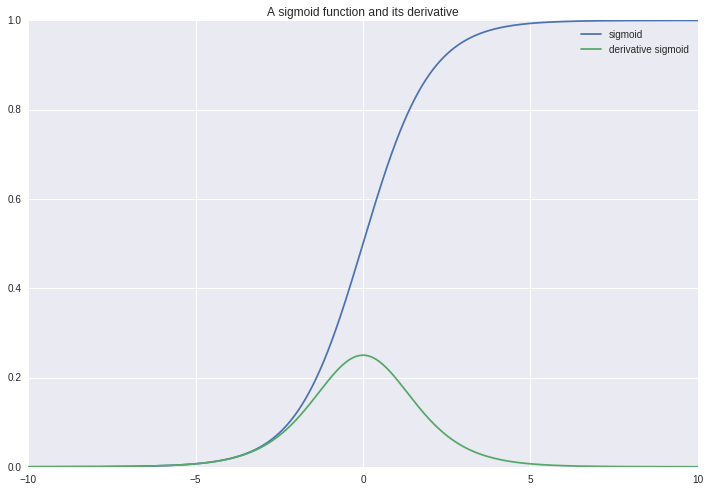

In [16]:
x = np.arange(-10, 10, 0.01)
y = sigmoid(x)
y_prime = sigmoid_prime(x)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x, y)
ax.plot(x, y_prime)
ax.set_title('A sigmoid function and its derivative')
ax.legend(['sigmoid', 'derivative sigmoid'], loc='best')
sns.despine()

# Neural network class

In [98]:
class NeuralNetwork(object):
    def __init__(self):
        self.input_layer_size = 2
        self.output_layer_size = 1
        self.hidden_layer_size = 3
        self.W_1 = np.random.rand(self.input_layer_size, self.hidden_layer_size)
        self.W_2 = np.random.rand(self.hidden_layer_size, self.output_layer_size)

        
        
    def forward(self, X):
        self.z_2 = np.dot(X, self.W_1)
        self.a_2 = sigmoid(self.z_2)
        self.z_3 = np.dot(self.a_2, self.W_2)
        y_hat = sigmoid(self.z_3)
        return y_hat
 


    def cost_function(self, X, y):
        return 0.5 * ((self.forward(X) - y) ** 2).sum()
 

    def cost_function_prime(self, X, y):
        self.y_hat = self.forward(X)
        error = (y- self.y_hat)
        delta_3 = np.multiply(-1 * error, sigmoid_prime(self.z_3))
        dJ_dW_2 = np.dot(self.a_2.T, delta_3)
        delta_2 = np.dot(delta_3, self.W_2.T) * sigmoid_prime(self.z_2)
        dJ_dW_1 = np.dot(X.T, delta_2)
        return dJ_dW_1, dJ_dW_2
    
    def get_params(self):
        """
        Get the W_1 and W_2 parameters into vector forms
        """
        nn_params = np.concatenate((self.W_1.ravel(), self.W_2.ravel())) 
        return nn_params

    
    def set_params(self, params):
        """
        Set the W_1 and W_2 parameters (into the correct shapes) from a vector of parameters
        Args: 
            params(ndarry): A vector containing the W_1 and W_2 parameters concatenated
        """
        W_1_vector = params[0:self.input_layer_size * self.hidden_layer_size]
        self.W_1 = np.reshape(W_1_vector, (self.input_layer_size, self.hidden_layer_size))
        W_2_end = self.input_layer_size * self.hidden_layer_size + self.hidden_layer_size * self.output_layer_size
        W_2_vector = params[self.input_layer_size * self.hidden_layer_size: W_2_end]
        self.W_2 = np.reshape(W_2_vector, (self.hidden_layer_size, self.output_layer_size))
 
        
    def compute_gradients(self, X, y):
        """
        Compute the cost function gradients (with regards to W_1 and W_2) and return the result
        into a vector
        """
        dJ_dW_1, dJ_dW_2 = self.cost_function_prime(X, y)
        return np.concatenate((dJ_dW_1.ravel(), dJ_dW_2.ravel()))

# Numerical gradient computation

In [99]:
def compute_numerical_gradient(N, X, y):
    """
    Compute a numerical approximation to the NN gradient by introducting 
    a small perturbation (adding and substracting epsilon)
    """
    initial_params = N.get_params()
    num_gradient = np.zeros(initial_params.shape)
    perturbation = np.zeros(initial_params.shape)
    epsilon = 1e-4
    for p in range(len(initial_params)):
        perturbation[p] = epsilon
        N.set_params(initial_params + perturbation)
        loss_plus = N.cost_function(X, y)
        N.set_params(initial_params - perturbation)
        loss_minus = N.cost_function(X, y)     
        num_gradient[p] = (loss_plus - loss_minus) / (2* epsilon)
        perturbation[p] = 0
    N.set_params(initial_params)
    return num_gradient

In [107]:
def test_gradient(N, X,y):
    """
    Check that the gradient is correctly implemented by comparing it to a numerical approximation
    """
    gradient = N.compute_gradients(X,y)
    numerical_gradient = compute_numerical_gradient(N, X, y)
    norm_minus = np.linalg.norm(gradient - numerical_gradient)
    norm_plus = np.linalg.norm(gradient + numerical_gradient)
    norm_ratio = float(norm_minus) / norm_plus
    try:
        np.testing.assert_almost_equal(norm_ratio, 1e-8)
        print('The gradient is correctly implemented. Well done!')
    except AssertionError:
        print('There is an error in your gradient implementation. Please check the code!')

# Gradient descent ([BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) method)

In [43]:
class Trainer(object):
    def __init__(self, N):
        self.N = N
    def cost_function_wrapper(self, params, X,y):
        """
        A wrapper for the NN cost function that has the appropriate interface (inputs and outputs) 
        for the optimize.minimize scipy function
        """
        self.N.set_params(params)
        cost = self.N.cost_function(X,y)
        gradient = self.N.compute_gradients(X, y)
        return cost, gradient
    
    def callback(self, params):
        self.N.set_params(params)
        self.J.append(self.N.cost_function(self.X, self.y))
        
    def train(self, X, y):
        self.X = X
        self.y = y
        self.J = []
        options = {'maxiter': 200, 'disp': True}
        params_0 = self.N.get_params()
        _res = optimize.minimize(self.cost_function_wrapper, params_0, jac=True, 
                                 method='BFGS', args=(X,y), options=options, callback=self.callback)
        self.N.set_params(_res.x)
        self.optimization_results = _res

# Putting everything together for the training step

In [74]:
# Iris data
iris_data = load_iris()
iris_X = iris_data.data[0:3, 0:2]
iris_y = np.array([[l] for l in iris_y], dtype=float) # Some shape tweaking so that it works with the NN

In [34]:
# Video data
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

# Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

## Start with testing the gradient function implementation

In [108]:
nn = NeuralNetwork()
test_gradient(nn, X,y)

The gradient is correctly implemented. Well done!


## With the video provided data

In [48]:
%%time
nn = NeuralNetwork()
t = Trainer(nn)
t.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000409
         Iterations: 64
         Function evaluations: 88
         Gradient evaluations: 88
CPU times: user 20.2 ms, sys: 8 µs, total: 20.2 ms
Wall time: 19.5 ms


## With the iris data set

In [73]:
%%time
nn = NeuralNetwork()
t = Trainer(nn)
t.train(iris_X,iris_y)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 28
         Function evaluations: 32
         Gradient evaluations: 32
CPU times: user 8.65 ms, sys: 45 µs, total: 8.69 ms
Wall time: 8.14 ms
